In [1]:
import pickle
import time
from rich.progress import track
import numpy as np
import math
from scipy.special import binom, perm
from itertools import combinations, permutations, product
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy

import random
from deap import base, creator, tools

from olympus.surfaces import CatCamel, CatMichalewicz, CatSlope, CatDejong # cat
from olympus.surfaces import Branin, Michalewicz, Levy, Dejong # cont

In [2]:
#------------------
# HELPER FUNCTIONS
#------------------
def stirling_sum(Ns):
    """ ...
    """
    stirling = lambda n,k: int(1./math.factorial(k) * np.sum([(-1.)**i * binom(k,i)*(k-i)**n for i in range(k)]))
    return np.sum([stirling(Ns, k) for k in range(Ns+1)])

def partition(S):
    """ ...
    """
    if len(S) == 1:
        yield [S]
        return 

    first = S[0]
    for smaller in partition(S[1:]):
        for n, subset in enumerate(smaller):
            yield smaller[:n]+[[first] + subset]+smaller[n+1:]
        yield [[first]]+smaller 
    
def gen_partitions(S):
    """
    generate all possible partitions of Ns-element set S
    
    Args: 
        S (list): list of non-functional parameters S
    """
    return [p for _, p in enumerate(partition(S),1)]


def gen_permutations(X_funcs, Ng):
    """ generate all possible functional parameter permutations
    given number of non-functional parameter subsets Ng
    
    Args: 
        X_funcs (np.ndarray): numpy array with all functional 
            possile functional parameters
        Ng (int): number of non-functional parameter subsets
        
    Returns
        (np.ndarray): array of parameter permutations of
            shape (# perms, Ng, # params)
    """
    
    return np.array(list(permutations(X_funcs, Ng)))

def measure_objective(xgs, G, surf_map):
    """ ... 
    """
    f_x = 0.
    for g_ix, Sg in enumerate(G):
        f_xg = 0.
        for si in Sg:
            f_xg += measure_single_obj(xgs[g_ix], si, surf_map)
        f_x += f_xg / len(Sg)

    return f_x


def estimate_optimum(S, surf_map, num_samples=1e5, is_categorical=False):
    
    f_xs = [] 
    start_time = time.time()
    
    # generate all the partitions of non-functional parameters
    Gs = gen_partitions(S)
    print('total non-functional partitions : ', len(Gs))
    
    for G_ix, G in track(enumerate(Gs), total=len(Gs), description='Evaluating candidates'):
        Ng = len(G)
        if is_categorical:
            # categorical surfaces
            opts = [f'x{i}' for i in range(21)]
            X_funcs = np.random.choice(opts, replace=True, size=(num_samples, Ng, 2))            
        else:
            # continuous surface
            # generate samples
            X_funcs =  np.random.uniform(size=(num_samples, Ng, 2)) # 2d functions only
        
        for X_func in X_funcs:
            f_x = measure_objective(X_func, G, surf_map)
            f_xs.append({'G': G, 'X_func': X_func,'f_x': f_x,})

    total_time = round(time.time()-start_time,2)
    print(f'[INFO] Done in {total_time} s')
    return f_xs


def record_merits(S, surf_map, X_func_truncate=20):
    
    # list of dictionaries to store G, X_func, f_x
    f_xs = [] 
    
    start_time = time.time()
    
    # generate all the partitions of non-functional parameters
    Gs = gen_partitions(S)
    print('total non-functional partitions : ', len(Gs))
    
    # generate all the possible values of functional parametres
    # assume all surfs have same # options, params
    param_opts = [f'x{i}' for i in range(surf_map[0].num_opts)] 
    params_opts = [param_opts for _ in range(surf_map[0].param_dim)]
    cart_product = list(product(*params_opts))
    X_funcs = np.array([list(elem) for elem in cart_product])
    
    if isinstance(X_func_truncate,int):
        X_funcs = X_funcs[:X_func_truncate, :]
    print('cardnality of functional params : ', X_funcs.shape[0])
    
    for G_ix, G in enumerate(Gs): 
        Ng = len(G)
        # generate permutations of functional params
        X_func_perms = gen_permutations(X_funcs, Ng)
        if G_ix % 1 == 0:
            print(f'[INFO] Evaluating partition {G_ix+1}/{len(Gs)+1} with len {Ng} ({len(X_func_perms)} perms)')
        for X_func in track(X_func_perms, description='Evaluating permutations...'):
            # measure objective 
            f_x = measure_objective(X_func, G, surf_map)
            # store values
            f_xs.append({'G': G, 'X_func': X_func,'f_x': f_x,})
    total_time = round(time.time()-start_time,2)
    print(f'[INFO] Done in {total_time} s')
    
    return f_xs

def measure_single_obj(X_func, si, surf_map):
    X_func = list([str(elem) for elem in X_func])
    return surf_map[si].run(X_func)[0][0]

In [3]:
#-------------
# TOY PROBLEM
#-------------
#S = [0, 1, 2, 3] # four non-functional parameter options 
S = [0, 1, 2, 3]
surf_map_cat = {
    0: CatCamel(param_dim=2, num_opts=21),
    1: CatDejong(param_dim=2, num_opts=21),
    2: CatMichalewicz(param_dim=2, num_opts=21),
    3: CatSlope(param_dim=2, num_opts=21),
}
surf_map_cont = {
    0: Branin(),
    1: Dejong(),
    2: Michalewicz(),
    3: Levy(),
}

## Begin MEDUSA genetic algorithm

In [4]:
def dummy_evaluate(individual):
    return np.random.uniform(),

def evaluate(individual):
    G = individual['G']
    X_func = individual['X_func']
    f_x = 0.
    for g_ix, Sg in enumerate(G):
        f_xg = 0.
        for si in Sg:
            f_xg += measure_single_obj(X_func[g_ix], si, surf_map_cont)
        f_x += f_xg / len(Sg)

    return f_x,
    
    
    return sum(individual),

def init_population(num_inds=10):
    population = []
    for ind in range(num_inds):
        # generate G
        S = [0, 1, 2, 3]
        random.shuffle(S)
        max_Ng = 3
        Ng = np.random.randint(1,max_Ng+1)
        G = [sorted(S[i::Ng]) for i in range(Ng)]
        # generate X_func
        # i.e. sample Ng parameters from param_space
        param_dim = 2
        X_func = []
        for _ in range(Ng):
            X_func.append(list(np.random.uniform(0,1,size=(param_dim,))))
            
        # create individual
        ind = creator.Individual({'G':G, 'X_func':X_func, 'Ng': len(G)})
        population.append(ind)
    return population

def custom_mutate_G(ind):
    """ mutate non-functional param assignments G
    """
    
    # determine whether we are making a mutation to G
    mutation_types = ['fusion', 'swap', 'split'] #'fusion', 'split']
    mutated = False
    while not mutated and len(mutation_types)>0:
        mutation_type = np.random.choice(mutation_types)
        
        #---------------
        # SWAP MUTATION
        #---------------
        if mutation_type == 'swap':
            # swap one general param from one subset to another
            if not len(ind['G'])>1:
                mutation_types.remove(mutation_type)
            else:
                mut_locs = np.random.choice(
                    np.arange(len(ind['G'])), size=(2,), replace=False,
                )
                mut_loc_1, mut_loc_2 = mut_locs[0], mut_locs[1]
                mut_ix_1 = np.random.randint(len(ind['G'][mut_loc_1]))
                mut_ix_2 = np.random.randint(len(ind['G'][mut_loc_2]))
                mut_val_1 = copy.deepcopy(ind['G'][mut_loc_1][mut_ix_1])
                mut_val_2 = copy.deepcopy(ind['G'][mut_loc_2][mut_ix_2])                
                # make swap
                ind['G'][mut_loc_1][mut_ix_1] = mut_val_2
                ind['G'][mut_loc_2][mut_ix_2] = mut_val_1

                mutated = True

        #----------------
        # FUSION MUTATION
        #----------------
        elif mutation_type == 'split':
            # fuse two subsets together at random
            if all([len(Sg)==1 for Sg in ind['G']]):
                mutation_types.remove(mutation_type)
            else:
                Sg_lens = np.array([len(Sg) for Sg in ind['G']])
                split_idxs = np.where(Sg_lens>1)[0]
                split_idx = np.random.choice(split_idxs)
                mut_val = copy.deepcopy(ind['G'][split_idx])
                
                np.random.shuffle(mut_val)
                if len(mut_val)==2:
                    num_splits, cutoff =1, [1]
                else:
                    num_splits = np.random.randint(1,len(mut_val)-1)
                    cutoff = sorted(np.random.choice(np.arange(1,len(mut_val)-1), size=(num_splits,), replace=False))
                chunks = []
                for ix in range(len(cutoff)):
                    if ix==0:
                        chunks.append(mut_val[:cutoff[ix]])
                    else:
                        chunks.append(mut_val[cutoff[ix-1]:cutoff[ix]])
                    if ix == len(cutoff)-1:
                        chunks.append(mut_val[cutoff[ix]:])
                        
                del ind['G'][split_idx]
                ind['G'].extend(sorted(c) for c in chunks)
                ind['G'] = sorted(ind['G'])
                
                mutated=True
                
        elif mutation_type == 'fusion':
            # split one group at random
            # TODO: eventually make sure the split will not exceed the 
            # maximum allowed subsets
            if not len(ind['G'])>1:
                mutation_types.remove(mutation_type)
            else:
                mut_idx = sorted(
                    np.random.choice(np.arange(len(ind['G'])), size=(2,), replace=False), reverse=True
                )
                mut_1_val = copy.deepcopy(ind['G'][mut_idx[0]])
                mut_2_val = copy.deepcopy(ind['G'][mut_idx[1]])
                new_Sg = sorted(mut_1_val + mut_2_val)
                for idx in mut_idx:
                    del ind['G'][idx]
                ind['G'].append(new_Sg)
                ind['G'] = sorted(ind['G'])
                mutated=True
        else:
            pass

    return ind
        

def custom_mutate_X_func(ind, indpb=0.3, continuous_scale=0.1, discrete_scale=0.1):
    """ mutation for X_func functional parameters
    """
    PARAM_SPACE_DIM = 2 # make this class attr
    PARAM_TYPE = 'continuous' # check with param space here
    BOUND_LOW = 0.
    BOUND_HIGH = 1. 
    
    assert len(ind['X_func']) == ind['Ng']
    G_mut_diff = len(ind['G']) - ind['Ng']
    
    if G_mut_diff < 0:
        # subset(s) were removed, need to reduce number of X_func
        remove_idx = sorted(
            np.random.choice(np.arange(ind['Ng']), size=(abs(G_mut_diff,)), replace=False), reverse=True
        )
        for idx in remove_idx:
            del ind['X_func'][idx]
        ind['Ng'] = len(ind['G']) # reset Ng
        
    elif G_mut_diff > 0:
        # subset(s) were added,  need to inflate the number of X_func
        if len(ind['X_func'])==1:
            duplicate_idx = [0]*G_mut_diff
        else:
            duplicate_idx = sorted(
                np.random.choice(np.arange(ind['Ng']), size=(G_mut_diff,), replace=False), reverse=True
            )
        duplicate_vals = [ind['X_func'][idx] for idx in duplicate_idx]
        ind['X_func'].extend([val for val in duplicate_vals])
        
        ind['Ng'] = len(ind['G']) # reset Ng
    
    # perform a Gaussian mutation
    for X_func_ix in range(len(ind['X_func'])):
        # TODO: could add another probability here...
        for param_ix in range(PARAM_SPACE_DIM):
            if random.random() < indpb:
                
                if PARAM_TYPE == 'continuous':
                    scale = (BOUND_HIGH - BOUND_LOW) * continuous_scale
                    ind['X_func'][X_func_ix][param_ix] += np.random.normal(loc=0.0, scale=scale)
                    ind['X_func'][X_func_ix][param_ix] = _project_bounds(
                        ind['X_func'][X_func_ix][param_ix], BOUND_LOW, BOUND_HIGH
                    )
                    
                elif PARAM_TYPE == 'discrete':
                    # TODO
                    pass
                elif PARAM_TYPE == 'categorical':
                    # TODO
                    pass 
                else:
                    raise ValueError()
        
    return ind


def _project_bounds(x, x_low, x_high):
    if x < x_low:
        return x_low
    elif x > x_high:
        return x_high
    else:
        return x

In [5]:
creator.create('FitnessMin', base.Fitness, weights=(-1.0,)) 
creator.create('Individual', dict, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register('population', init_population)
toolbox.register('evaluate', evaluate)

# mutation/selection opertations operations
# toolbox.register("mutate_X_func", tools.mutGaussian, mu=0, sigma=1, indpb=0.1)
toolbox.register("select", tools.selTournament, tournsize=3)

toolbox.register('mutate_G', custom_mutate_G)
toolbox.register('mutate_X_func', custom_mutate_X_func, indpb=0.3)

In [6]:
def main():
    pop = toolbox.population(num_inds=100)
    NGEN = 100
    mutate_G_pb = 0.25
    mutate_X_func_pb = 0.4

    # Evaluate the entire population
    fitnesses = map(toolbox.evaluate, pop)
    for ind, fit in zip(pop, fitnesses):
        ind.fitness.values = fit
    
    # create hall of fame
    num_elites = int(round(0.05 * len(pop), 0))  # 5% of elite individuals
    halloffame = tools.HallOfFame(num_elites)  # hall of fame with top individuals
    halloffame.update(pop)
    
    # register some statistics and create logbook
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", np.mean)
    stats.register("std", np.std)
    stats.register("min", np.min)
    stats.register("max", np.max)

    logbook = tools.Logbook()
    logbook.header = ["gen", "nevals"] + (stats.fields if stats else [])
    record = stats.compile(pop) if stats else {}
    logbook.record(gen=0, nevals=len(pop), **record)
    

    for gen in track(
            range(1, NGEN+1),
            total=NGEN,
            description="Optimizing proposals...",
            transient=False,
    ):
        
        # size of hall of fame
        hof_size = len(halloffame.items) if halloffame.items else 0
        # Select the next generation individuals (allow for elitism)
        offspring = toolbox.select(pop, len(pop) - hof_size)
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))
        
        for mutant in offspring:
            # mutation on G
            if random.random() < mutate_G_pb:
                toolbox.mutate_G(mutant)
                # if G is mutated, mutate X_func immediately
                toolbox.mutate_X_func(mutant, indpb=mutate_X_func_pb) 
                del mutant.fitness.values
        
        # option for extra mutation on X_func
        for mutant in offspring:
            # mutation on X_func
            if random.random() < mutate_X_func_pb:
                toolbox.mutate_X_func(mutant, indpb=mutate_X_func_pb)
                del mutant.fitness.values

        # Evaluate the individual4s with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit
            
        # add the best back to population
        offspring.extend(halloffame.items)
        # Update the hall of fame with the generated individuals
        halloffame.update(offspring)

        # The population is entirely replaced by the offspring
        pop[:] = offspring    
        
        # Append the current generation statistics to the logbook
        record = stats.compile(pop) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        
    return pop, logbook

In [81]:
NUM_RUNS = 20

min_fitness_vals = []
num_evals = []

for _ in range(NUM_RUNS):
    _, logbook = main()
    run_min_fitness_vals = [gen['min'] for gen in logbook]
    run_num_evals = [gen['nevals'] for gen in logbook]
    
    min_fitness_vals.append(run_min_fitness_vals)
    num_evals.append(run_num_evals)
    
min_fitness_vals = np.array(min_fitness_vals)
num_evals = np.array(num_evals)

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

Output()

In [42]:
# estimate optimum of surface configuration
f_xs = estimate_optimum(S, surf_map_cont, num_samples=int(1e5), is_categorical=False)
vals = [d['f_x'] for d in f_xs]
best_idx = np.argmin(vals)
best_dict = f_xs[best_idx]
print(best_dict)

total non-functional partitions :  15


Output()

[INFO] Done in 58.98 s
{'G': [[0], [1, 2, 3]], 'X_func': array([[0.97436983, 0.17070893],
       [0.52715172, 0.4982644 ]]), 'f_x': 0.5671133217074137}


In [23]:
# estimate optimium for the categorical surfaces
f_xs = estimate_optimum(S, surf_map_cat, num_samples=int(1e3), is_categorical=True)
vals = [d['f_x'] for d in f_xs]
print(vals)
best_idx = np.argmin(vals)
best_dict = f_xs[best_idx]
print(best_dict)

total non-functional partitions :  15


Output()

[WARNING] Not all parameters of ['x3' 'x18'] are within bounds!
[WARNING] Not all parameters of ['x3' 'x18'] are within bounds!
[WARNING] Not all parameters of ['x3' 'x18'] are within bounds!
[WARNING] Not all parameters of ['x3' 'x18'] are within bounds!
[WARNING] Not all parameters of ['x0' 'x15'] are within bounds!
[WARNING] Not all parameters of ['x0' 'x15'] are within bounds!
[WARNING] Not all parameters of ['x0' 'x15'] are within bounds!
[WARNING] Not all parameters of ['x0' 'x15'] are within bounds!
[WARNING] Not all parameters of ['x15' 'x14'] are within bounds!
[WARNING] Not all parameters of ['x15' 'x14'] are within bounds!
[WARNING] Not all parameters of ['x15' 'x14'] are within bounds!
[WARNING] Not all parameters of ['x15' 'x14'] are within bounds!
[WARNING] Not all parameters of ['x19' 'x15'] are within bounds!
[WARNING] Not all parameters of ['x19' 'x15'] are within bounds!
[WARNING] Not all parameters of ['x19' 'x15'] are within bounds!
[WARNING] Not all parameters of [

[WARNING] Not all parameters of ['x10' 'x20'] are within bounds!
[WARNING] Not all parameters of ['x13' 'x13'] are within bounds!
[WARNING] Not all parameters of ['x7' 'x16'] are within bounds!
[WARNING] Not all parameters of ['x12' 'x20'] are within bounds!
[WARNING] Not all parameters of ['x14' 'x13'] are within bounds!
[WARNING] Not all parameters of ['x15' 'x13'] are within bounds!
[WARNING] Not all parameters of ['x9' 'x13'] are within bounds!
[WARNING] Not all parameters of ['x5' 'x14'] are within bounds!
[WARNING] Not all parameters of ['x1' 'x20'] are within bounds!
[WARNING] Not all parameters of ['x8' 'x19'] are within bounds!
[WARNING] Not all parameters of ['x10' 'x17'] are within bounds!
[WARNING] Not all parameters of ['x12' 'x15'] are within bounds!
[WARNING] Not all parameters of ['x1' 'x18'] are within bounds!
[WARNING] Not all parameters of ['x19' 'x19'] are within bounds!
[WARNING] Not all parameters of ['x6' 'x17'] are within bounds!
[WARNING] Not all parameters of 

[INFO] Done in 1.5 s
[503698.122241036, 307486.16857656126, 23003389.27968153, 4890898.82860793, 3222710.1682102643, 789.1205025972962, 14315.98199340282, 50170822.578272484, 1555.0505380836332, 98064.07770832161, 187502.331293432, 19984747.240805462, 1294.0570359981093, 1364.0452166211542, 10763.084316912147, 646157.8585539033, 21081.730565023263, 3128508.987884845, 463.08110225069316, 97735.11464792505, 110727.39003433698, 325.56595247852914, 19366.2568125442, 142949113.26687708, 1811904.7839214767, 2859320.1514741387, 644452.4175028079, 814734.40526049, 21896.269916234454, 2833245.622755946, 47302.38367010992, 549.8879845288449, 187502.331293432, 20845.407565201913, 121874.86149079475, 151418.73488785824, 15402804.49413818, 434445.9382162322, 14904886.11853651, 41.74550874495305, 293783.90544389066, 335.13248413777603, 11060741.02270629, 238469.69059806058, 312.45872552671483, 23003389.27968153, 187502.331293432, 227608.59764121764, 34321341.00734059, 6477399.565571255, 78638343.059

In [25]:
print(best_dict)

{'G': [[0, 1, 2, 3]], 'X_func': array([['x4', 'x6']], dtype='<U3'), 'f_x': 6.293602946929202}


mean num evals :  6034.8


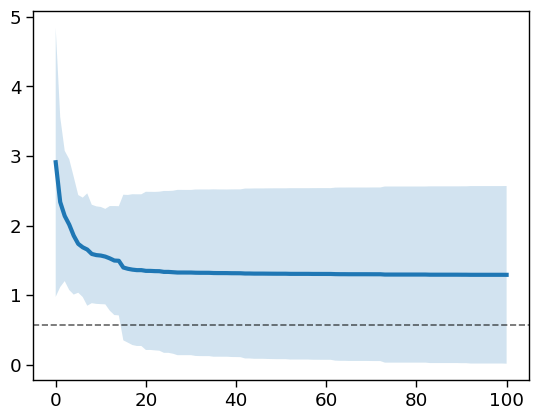

In [82]:
fig, ax = plt.subplots()
NGEN = 101

mean_trace = np.mean(min_fitness_vals,axis=0)
std_trace = np.std(min_fitness_vals,axis=0)

mean_num_evals = np.mean(np.sum(num_evals, axis=1))
print('mean num evals : ', mean_num_evals)

est_best_val = best_dict['f_x']

ax.plot(np.arange(NGEN), mean_trace, lw=3)
ax.fill_between(
    np.arange(NGEN),
    mean_trace+1.96*std_trace,
    mean_trace-1.96*std_trace,
    alpha=0.2,
)

ax.axhline(est_best_val, ls='--', c='k', alpha=0.6)

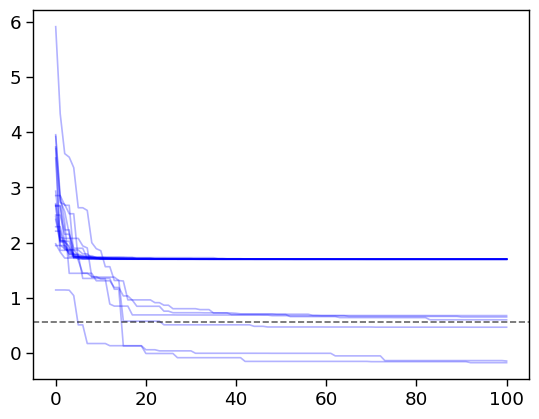

In [83]:
# plot individual traces
fig, ax = plt.subplots()
NGEN = 101

est_best_val = best_dict['f_x']

for trace in min_fitness_vals:
    ax.plot(np.arange(NGEN), trace, c='b', alpha=0.3)

ax.axhline(est_best_val, ls='--', c='k', alpha=0.6)

In [64]:
num_evals.shape

(20, 101)

array([3582, 3557, 3654, 3583, 3672, 3633, 3622, 3593, 3566, 3620, 3663,
       3572, 3548, 3611, 3598, 3635, 3636, 3625, 3573, 3561])

In [9]:
# get the minimum of the each cat surface 
mins_ = []
for ix, surf in surf_map_cat.items():
    print(surf.minima)
    mins_.append(surf.minima[0]['value'])

[{'params': ['x7', 'x11'], 'value': 12.177205282080257}]
[{'params': ['x10', 'x10'], 'value': 0.0}]
[{'params': ['x14', 'x10'], 'value': -1.8010702893119994}]
[{'params': ['x0', 'x0'], 'value': 0.0}]


In [10]:
np.sum(mins_)

10.376134992768257

In [11]:
vals_ = []
param = ['x4', 'x6']
for ix, surf in surf_map_cat.items():
    meas = surf.run(param)[0][0]
    vals_.append(meas)

In [12]:
vals_

[15385.045190238216,
 13.631488000000001,
 -3.079258822176041e-06,
 0.47619047619047616]

In [13]:
sum(vals_)

15399.15286563515